# VELOCITY/KINETIC ENERGY CALCULATION

This notebook contains the code to calculate velocity and kinetic energy of the particles (metallic spheresin the vibrating platform) by means of the DataFrames with the positions and the trajectories of the particles previously processed with other code.

There are some libraries that are used, such as numpy, pandas, matplot or trackpy. In addition, some functions are defined to simplify the DataFrames as well as to calculate the velocity.

The structure of the code below is as follows:
1. Load and import Python Libraries.

2. Defined the functions that are used to obtain the parameters from the DataFrames and after that calculate the velocity (and the kinetic energy). 
* There are some extra auxiliary functions that are useful for checking the data.
    
3. Import the Dataframes under study.

4. Calculate the velocity and apend the data to the dataframe with new columns.

5. Export and save the data.


# 1. LOAD PYTHON LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trackpy as tp

#interactive graphics
%matplotlib widget 

from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image

L= 800 # system size (pixels)

#  2. DEFINITION OF ALL FUNCTIONS

## __tracks_len:__ get list of tracks ids; and no. of tracks

INPUT: data frame 'df' with tracks

OUTPUT: 
* lengths: array with lenghts of all tracks
* track_list: array with tracks IDs 
* ntracks: no. of tracks

## __reindex_tracks:__ resets tracks IDs in logical order: 1,2,3...., ntracks

INPUT: 

* df: data frame with tracks
* arr: array with tracks list

OUTPUT: data frame with 'track' column modified

In [3]:
def tracks_len(df):
    track_list = np.unique(df.track.values) # list of current track_listk IDs
    ntracks = len(track_list)
    lengths = np.array( [len(df[df.track==i]) for i in track_list] ) # length of each track
    return track_list, lengths, ntracks

def reindex_tracks(df, arr):
    # replace tracks IDs with logical order count
    ntracks = len(arr)
    for i in range(ntracks):
        df.loc[df.track == arr[i],'track'] = i
    return df

## Velocity, <v²> calculation and plotting

### velocity(df)

For each trajectory velocity is calculated by means of the difference between positions along the trajectory.

### <v²>(velocity)
Once the velocity for each instant of the trajectory is calculated and it has been added to the dataframe, the <v²> can be calculated. 

Here it is important to clarify if filtering the previous velocity data is needed to drop big values (that correspond to changes of regions through colissions between two particles).

### Plot <v²>
Plot the <v²> for each instant (frame).

In [13]:
# suggestion:

# tr = track(df, id)
# vx = (tr.x[1:] - tr.x[:-1]) * fps
# vy = (tr.y[1:] - tr.y[:-1] ) * fps
# fps being frames per second
# v2 = vx**2 + vy**2
# temp = np.mean(v2) # this should be temperature/mass in units of pixel/s


def velocity(df):
    out=pd.DataFrame()
    for i in range(ntracks):
        sub=df[df.track==i]
        vxvy = sub[['x','y']].diff(periods=-1)
        v=(vxvy.x**2+vxvy.y**2)**(0.5)
        v2=v**2
        sub=sub[:-1]
        sub['vx']=vxvy.x
        sub['vy']=vxvy.y
        sub['v']=v
        sub['v2']=v2
        out=pd.concat([out,sub],ignore_index=True)
        if i%100==0:
            print(i)
    return out

def v2media(vel,t_id):
    vel=vel[vel.v<1];
    vel=vel[vel.track==t_id];
    v2media=np.zeros(nt);
    for i in range(nt):
        v2media[i]=vel[vel.frame==i][['v2']].mean(axis=0)[0]
    return v2media

def v2plot(v2media):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_title('<v²> in each frame')
    ax.set_xlim(0,nt)
    ax.plot(v2media, '.', c='b')


# 3. READ DATAFRAME (from pickle file)

Para automatizarlo, habría que hacer un bucle con todos los cálculos juntos.

Hay que aclarar si es necesario filtrar para aquellos picos de velocidad correspondiente a las colisiones aisladas de las partículas.


In [6]:
data = pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.003125_f75Hz.pkl')
data = data.rename(columns={'particle':'track'})

time=np.loadtxt('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/frametime_densidad0.003125_f75Hz.txt')

nt = np.max(data.frame.values) # number of frames (assumming there is at least one complete track)
print('no. of frames in block: ', nt)
print('\ndata frame head\n')
data.head(10)


no. of frames in block:  38418

data frame head



,x,y,frame,track
0,596.455101,135.880345,0,0
1,436.032520,668.054468,0,1
2,642.276737,663.970326,0,2
3,326.168105,631.152426,0,3
4,249.043868,610.351917,0,4
5,280.133984,603.833948,0,5
6,387.708165,594.131472,0,6
7,424.940380,588.471361,0,7
8,234.825538,586.125290,0,8
9,288.843942,539.752632,0,9


### Obtain tracks list, total number and length of each track

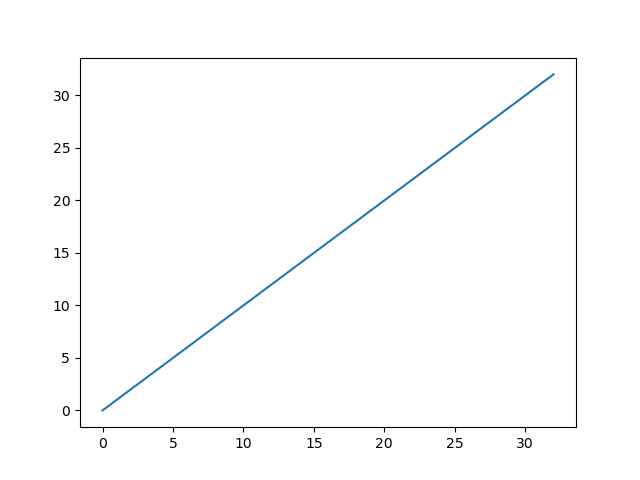

In [7]:
track_list, lengths, ntracks = tracks_len(data)
plt.plot(track_list); # reindex track list is only necessary if this plot is not a straight line

### Function to plot trajectories through the index of the track

run 'plot.close(t_id)' when finished



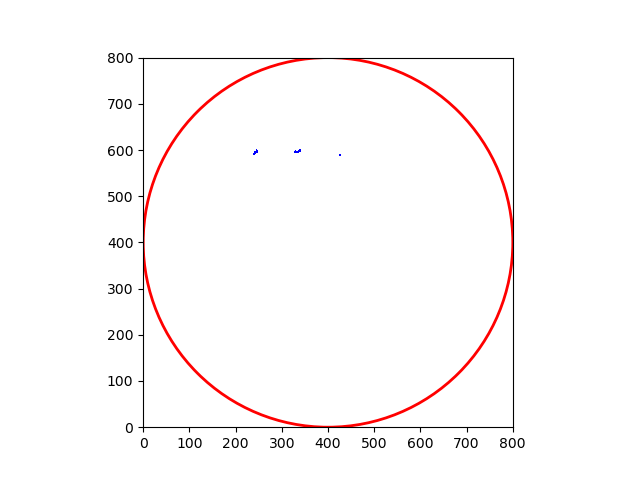

In [78]:
t_id = 7
plot_track(data, t_id)

In [32]:
plt.close(t_id)

## Velocity calculation
#### These are the cells to calculate the velocity for each dataframe

0


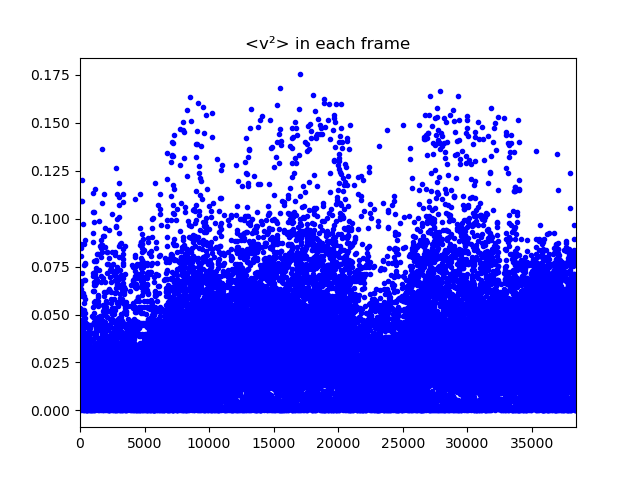

In [14]:
vel=velocity(data)
v2media=v2media(vel,10)
v2plot(v2media)

# * AUXILIARY FUNCTIONS *

## __split_short:__ SPLITS data frame into 3: one with short tracks and one with long enough tracks, and one with tracks with intermediate length (if limits are unequal)

INPUT
* df: data frame of tracks to split
* larr: list of lengths of each track
* ili: first threshold length; tracks longer than 'il' go to the long or intermediate tracks sub data frame
* ilf: second threshold; maximum length for the intermediate tracks

OUTPUT
* df_long, df_short: long, middle, and short tracks sub data frames, respectively

In [33]:
def split_short(df, larr, ili, ilf):
    # where: selects track indexes of length array whose values are < or >= than a value
    # isin: selects indexes of the table that fulfill condition in the line above,
    # in this case, track indexes for which value in length array is < or >= il
    # reset_index: resets data frame row index; drop=True means discard old row index
    df_short = df[df.track.isin(np.where(larr < ili)[0])].reset_index(drop=True)
    if ili != ilf:
        df_middle = df[ df.track.isin(np.where((larr >= ili) & (larr < ilf))[0]) ]
    else:
        df_middle = []
    df_long = df[df.track.isin(np.where(larr >= ilf)[0])].reset_index(drop=True)
    return df_long, df_middle, df_short

## Localize/characterize short tracks

## __n2d_plot:__ 2D tracks density

INPUT
* idf: figure index (just formal, needed by python)
* df: data frame with tracks
* nbins: no. of bins of histogram
* fs: figure size
* tit: figure title

OUTPUT

H: 2D tracks density field

In [35]:
def n2d_plot(idf, df,nbins,fs,tit):
    H, xedges, yedges= np.histogram2d(df.x.values, df.y.values, bins=nbins)
    H = H.T
    plt.figure(idf,figsize=(fs,fs))
    ax = plt.subplot()
    ax.set_title(tit)
    im = ax.imshow(H, cmap='nipy_spectral', origin='lower', interpolation='gaussian', 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]);
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%",pad=0.1)
    plt.colorbar(im, cax=cax)
    return H

In [76]:
def track(df, t_id):
    tr = df[df.track==t_id]
    return tr

def plot_track(df,t_id):
    fig = plt.figure(t_id)
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(0,L)
    ax.set_ylim(0,L)
    ax.set_aspect(1)
    ax.add_artist(plt.Circle((L/2,L/2),L/2, fill=False, edgecolor='r', linewidth=2));
    ax.plot(track(df, t_id).x.values, track(df,t_id).y.values, ',', c='b')
    print('run \'plot.close(t_id)\' when finished\n')


## Mass center trajectory calculation
## cm_t(df,t_id)

INPUT
* df: dataframe with particles data
* t_id= trajectory ID

OUTPUT

* xmean, ymean: Mean x,y position for trajectory t_id

In [75]:
def cm_t(df,t_id):
    tr = df[df.track==t_id] # suggestion: tr= track(df, id)
    xmean=tr.x.mean() # suggestion: remove
    ymean=tr.y.mean() # suggestion: remove
    return xmean,ymean # suggestion: return np.mean(tr.x), np.mean(tr.y)

def plot_cm(df,t_id): # suggestion: generalize plot_track function so that 
    # it will do both (tracks and mass center) either simultaneously or separately
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(0,L)
    ax.set_ylim(0,L)
    ax.set_aspect(1)
    ax.add_artist(plt.Circle((L/2,L/2),L/2, fill=False, edgecolor='r', linewidth=2));
    #ax.plot(track(df, t_id).x.values, track(df,t_id).y.values, ',', c='b')
    xmean,ymean=cm_t(df,t_id)
    ax.scatter(xmean,ymean,c='g',marker='.')
        
    #for i in range (nt):
     #   xmean,ymean=cm_t(df,i)
      #  ax.scatter(xmean,ymean,c='g',marker='.')
        

### In case the trajectories from the dataframe must be divided, this is the code

In [34]:
data_long, data_middle, data_short = split_short(data, lengths, 1000, 10000)

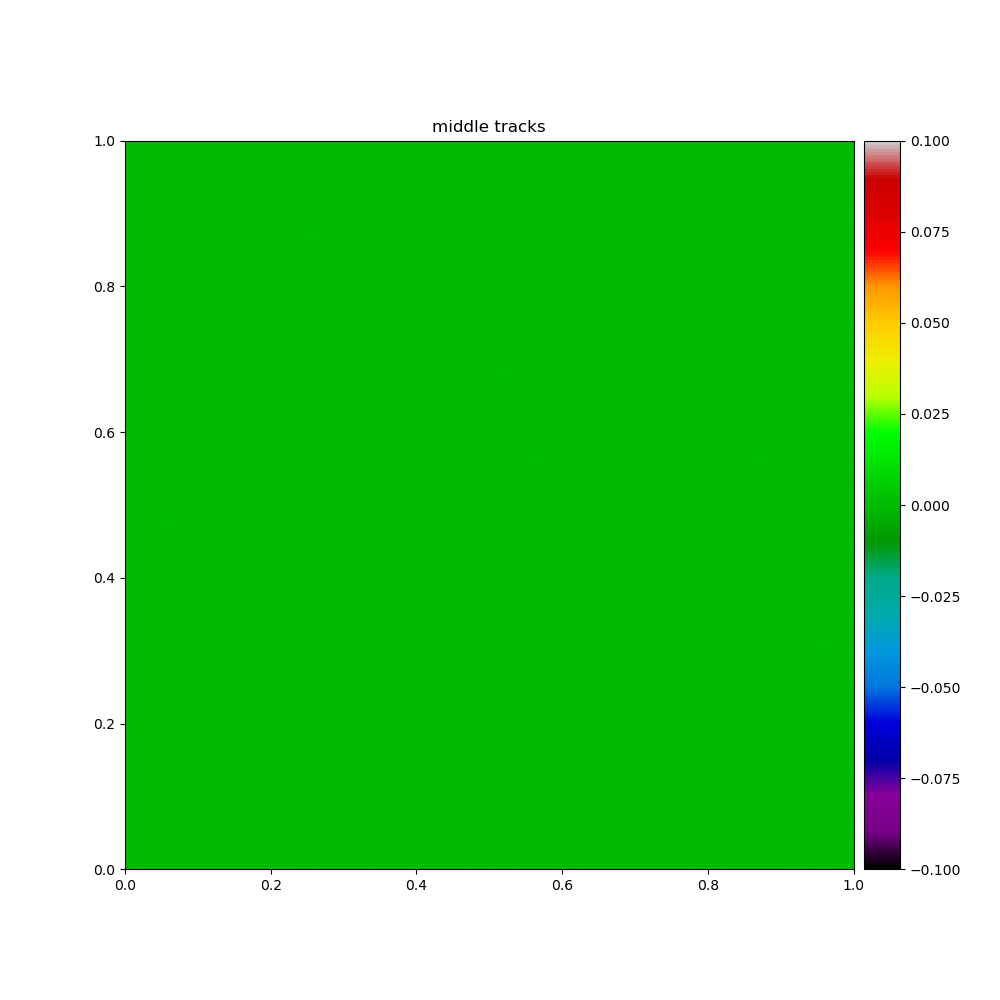

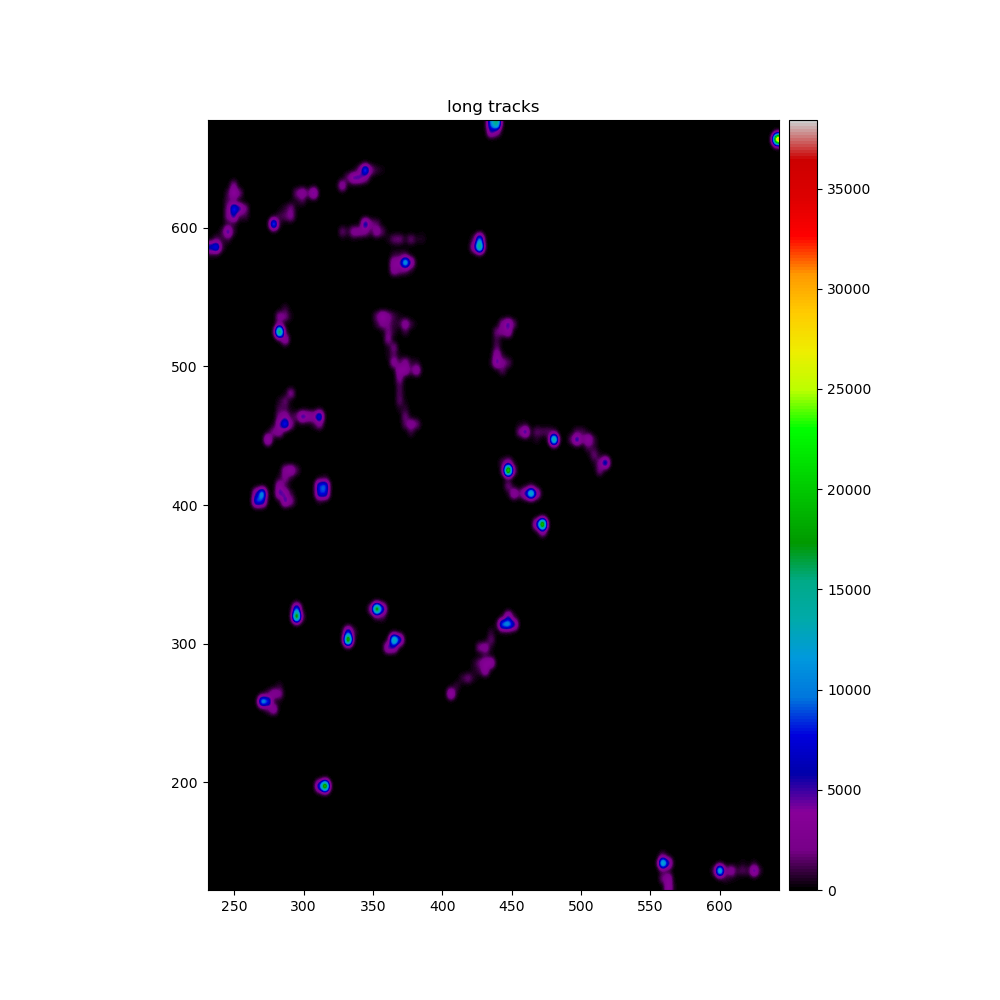

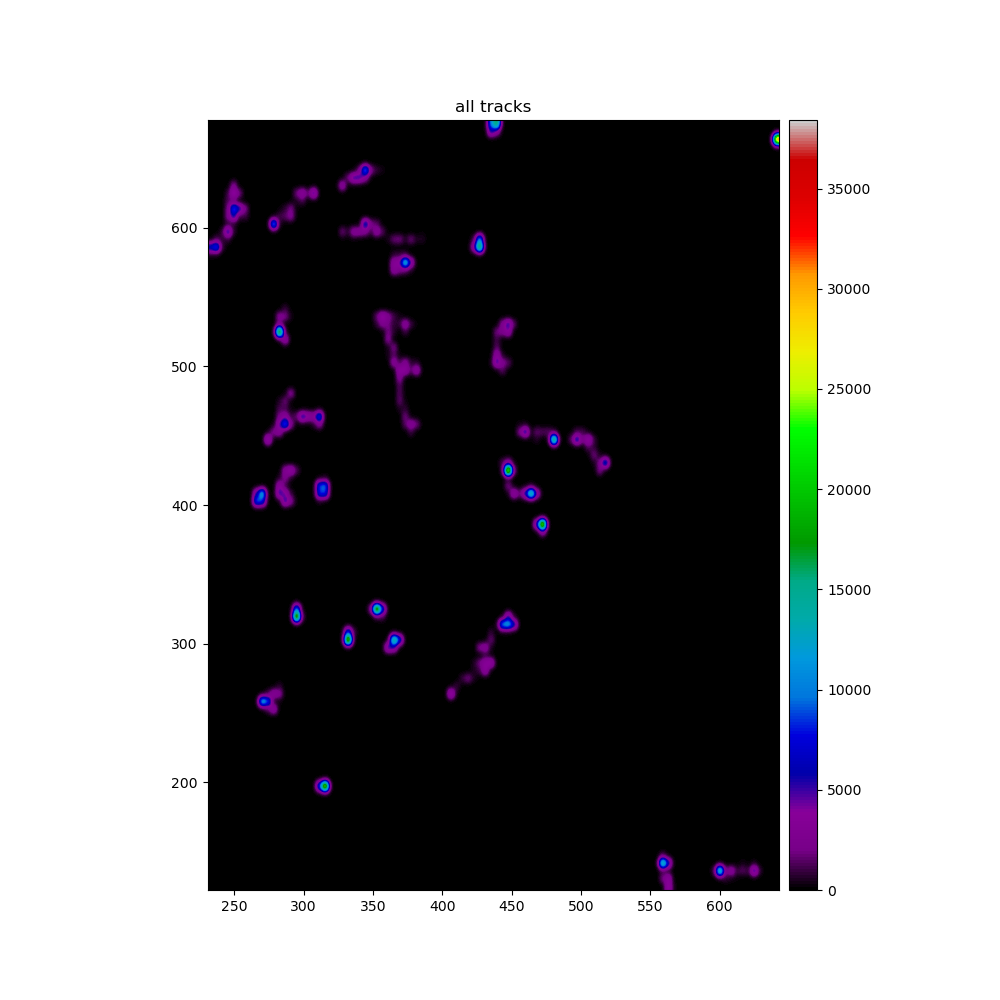

In [36]:
# short tracks particle density
H_short = n2d_plot(1, data_short, 100, 10, "short tracks")
# middle tracks 
H_middle = n2d_plot(2, data_middle, 100, 10, "middle tracks")
# long tracks
H_long = n2d_plot(3, data_long, 100, 10, "long tracks")
# all tracks particle density
H = n2d_plot(4, data, 100, 10, "all tracks")